In [46]:
%load_ext autoreload
%autoreload 2

import os, sys
# file_dir = os.path.dirname(__file__)
# sys.path.append(file_dir)
sys.path.append('/home/yz685/low_rank_BOPE')
sys.path.append('/home/yz685/low_rank_BOPE/low_rank_BOPE')
import warnings
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import torch
from torch import Tensor
from tqdm.auto import trange

from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.utils.sampling import draw_sobol_samples


from gpytorch import ExactMarginalLogLikelihood
from gpytorch.constraints import GreaterThan
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior
from low_rank_BOPE.bope_class import BopeExperiment
from low_rank_BOPE.test_problems.shapes import AreaUtil, Image
from low_rank_BOPE.test_problems.synthetic_problem import make_controlled_coeffs, make_problem, generate_principal_axes
from low_rank_BOPE.src.diagnostics import check_outcome_model_fit, check_util_model_fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
matrix_id = 6

CSVData = open(
    f"/home/yz685/low_rank_BOPE/low_rank_BOPE/test_problems/real_metric_corr/metric_corr_exp_{matrix_id}.csv")
metric_corr = np.loadtxt(CSVData, delimiter=",")

In [2]:
for i in range(7):
    CSVData = open(f"/home/yz685/low_rank_BOPE/low_rank_BOPE/test_problems/real_metric_corr/metric_corr_exp_{i}.csv")
    print(np.loadtxt(CSVData, delimiter=",").shape)

(69, 69)
(111, 111)
(128, 128)
(120, 120)
(56, 56)
(71, 71)
(45, 45)


In [3]:
metric_corr

array([[ 1.        ,  0.98030413,  0.61127194, ..., -0.30293051,
         0.24740711,  0.39062555],
       [ 0.98030413,  1.        ,  0.55908933, ..., -0.25086916,
         0.29267356,  0.36732735],
       [ 0.61127194,  0.55908933,  1.        , ..., -0.26745628,
         0.03672024,  0.16907694],
       ...,
       [-0.30293051, -0.25086916, -0.26745628, ...,  1.        ,
         0.12969605,  0.00115061],
       [ 0.24740711,  0.29267356,  0.03672024, ...,  0.12969605,
         1.        ,  0.55258851],
       [ 0.39062555,  0.36732735,  0.16907694, ...,  0.00115061,
         0.55258851,  1.        ]])

In [4]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit_transform(metric_corr)

array([[-2.52956381e+00,  4.56613075e-01,  4.40896991e-01, ...,
         2.69360508e-17, -2.92713571e-17,  1.61140478e-16],
       [-2.57017134e+00,  3.26720047e-01,  4.60229785e-01, ...,
        -4.12847369e-17, -8.56081559e-18, -1.22262707e-16],
       [-1.82037069e+00,  1.48039292e+00, -2.17767477e-01, ...,
        -4.96110483e-17, -1.64617830e-16,  1.83830609e-17],
       ...,
       [ 1.01784476e+00, -2.11980520e-02, -6.10054424e-01, ...,
        -1.79900351e-18,  1.79127877e-17,  7.60204905e-18],
       [-9.71889742e-01, -1.25748579e+00, -7.86461286e-01, ...,
        -5.62277474e-17,  9.77561034e-18,  2.23809455e-17],
       [-1.01852697e+00, -1.21423721e+00, -4.76614495e-01, ...,
         1.13042513e-17,  4.52990668e-17, -3.70393666e-17]])

Text(0.5, 1.0, 'Cumulative variance explained by successive principal components')

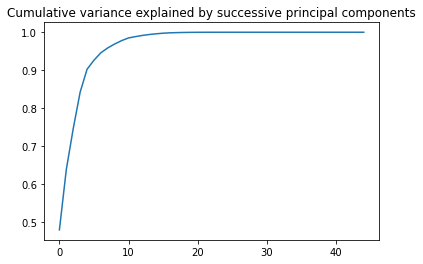

In [5]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative variance explained by successive principal components')

In [ ]:
# idea 1: use svd on the correlation matrix
# get the first few axes and singular values, 
# set those as ground truth axes and latent GP scaling factors

# we don't use cholesky
# chol_factor = np.linalg.cholesky(metric_corr + np.diag(np.ones(len(metric_corr))) * 1e-10)

# idea 2: use the full correlation matrix
# how to detangle the input correlation and task correlation?
# use kronecker structure?
# Suppose we have a vanilla Matern kernel over all inputs for all metrics
# is it as simple as idea 1, just using all axes, 
# or is there something else we can do?

In [3]:
# U and V are transposes of each other
# first few columns of U / first few rows of V

U, S, V = np.linalg.svd(metric_corr + np.diag(np.ones(len(metric_corr))) * 1e-10)

In [38]:
num_samples = 100
latent_dim = 10
outcome_dim = 45

PCs = np.random.multivariate_normal([0]*latent_dim, np.diag([1]*latent_dim), size = num_samples)
PCs_full = np.random.multivariate_normal([0]*outcome_dim, np.diag([1]*outcome_dim), size = num_samples)


In [39]:
# num_samples x 69np.matmul(PCs, V[:latent_dim] * np.expand_dims(np.sqrt(S[:latent_dim]), axis=1) )
Y = np.matmul(PCs, V[:latent_dim] * np.expand_dims(np.sqrt(S[:latent_dim]), axis=1) )


In [40]:
# argument should be a `outcome_dim x num_samples` data matrix, each col being an observation

emp_corr = np.corrcoef(Y.T)

In [ ]:
# TODO: check that metric_corr and emp_corr are "similar"
# how do we quantify similarity? 

In [31]:
def get_CMD(mat1, mat2):
    r"""
    A metric for correlation matrix distance developed in 
    https://www.researchgate.net/publication/4194743_Correlation_Matrix_Distance_a_Meaningful_Measure_for_Evaluation_of_Non-Stationary_MIMO_Channels

    Computes the following metric:    
        1-tr(mat1 @ mat2) / (Frobenius-norm(mat1) * Frobenius-norm(mat2))
    Equivalent to:
        1-dot(vec(mat1), vec(mat2)) / (L2-norm(vec(mat1)) * L2-norm(vec(mat2)))
    
    Takes values in [0,1]. The closer to 0, the more similar.
    """

    res = 1 - np.trace(np.matmul(mat1, mat2)) / (np.linalg.norm(mat1) * np.linalg.norm(mat2))   
    # np.linalg.norm() is the Frobenius norm by default
    
    return res

In [41]:
# can verify that the empirical correlation from the data is similar to metric_corr

get_CMD(metric_corr, emp_corr)

0.03525529833541652

In [ ]:
# in practice, we'd still use the PCATestProblem class,
# but make sure to pass in V[:latent_dim] as true_axes
# and sqrt(S[:latent_dim]) as PC_scaling_factors


In [47]:
full_axes = generate_principal_axes(
    output_dim=20,
    num_axes=20,
    dtype=torch.double,
    seed=0
)

In [48]:
true_axes = full_axes[:3]
scaling = [1,2,3]

In [50]:
problem = make_problem(
    input_dim = 2, 
    outcome_dim = 20,
    noise_std = 0.01,
    num_initial_samples = 32,
    true_axes = true_axes,
    PC_lengthscales = [0.5]*3,
    PC_scaling_factors = scaling,
    problem_seed = 5
)

/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/botorch/test_functions/base.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "bounds", torch.tensor(self._bounds, dtype=torch.float).transpose(-1, -2)
/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [ ]:
test_X = torch.randn((100, 2), dtype=torch.double)
test_Y = problem(test_X)

Y_corr = np.corrcoef(np.array(test_Y).T)

# normalize somehow?
# true_corr = true_axes^T @ S^2 @ true_axes

# Y_corr should be close to true_corr
